In [2]:
from __future__ import division, print_function, absolute_import

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import astropy.io.ascii as at
import astropy.units as u

# Define the circularization function

Following Meibom & Mathieu (2005), the circularization function $e(P_{orb})$ describes the transition from a median eccentricity for non tidally interacting binaries to complete circularization. The circularization period $P'$ indicates the period where all shorter-period binaries are circularized.

In [6]:
def circ_function(Porb,Pcirc,alpha=0.35,beta=0.14,gamma=1.0):
    """
    Compute the eccentricity distribution for the input
    Porb values. Alpha, beta, and gamma are taken from 
    Meibom & Mathieu (2005). 
    
    Inputs:
        Porb: array-like (Quantity optional)
        Pcirc: float (Quantity optional)
        alpha, beta, gamma: floats (optional)
        
    Outputs:
        eccentricity: array
    """
    
    eccentricities = np.zeros_like(Porb)
    
    # If Porb <= Pcirc, then e=0, so we don't need to change anything
    
    # If Porb > Pcirc, compute the circularization function
    
    gtr_pc = Porb > Pcirc
    
    cf_part = np.e**(beta * (Pcirc - Porb[gtr_pc]))
    
    eccentricities[gtr_pc] = alpha * (1 - cf_part)**gamma
    
    return eccentricities

In [11]:
ptest = np.logspace(0,3,100)
print(ptest[:10])

[ 1.          1.07226722  1.149757    1.23284674  1.32194115  1.41747416
  1.51991108  1.62975083  1.7475284   1.87381742]


In [12]:
etest = circ_function(ptest,10.2)

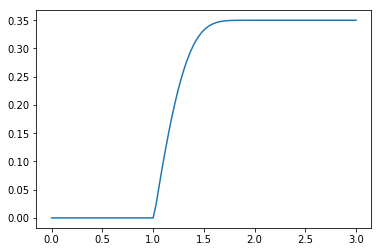

In [13]:
plt.plot(np.log10(ptest),etest)

# How about some data?

In [15]:
m35 = at.read("/home/stephanie/data/catalogs/M35_orbits_meibommathieu2005.csv")
print(m35.dtype)

[('2MASS ID', 'S16'), ('MS ID', 'S6'), ('CD ID', 'S6'), ('ra', 'S12'), ('dec', 'S12'), ('V', '<f8'), ('B-V', '<f8'), ('BinType', 'S3'), ('NRV', 'S5'), ('gamma', '<f8'), ('period', '<f8'), ('eccentricity', '<f8'), ('ecc_err', '<f8'), ('Pmem', 'S6'), ('M1', '<f8'), ('M2', 'S6'), ('SpT', 'S2')]


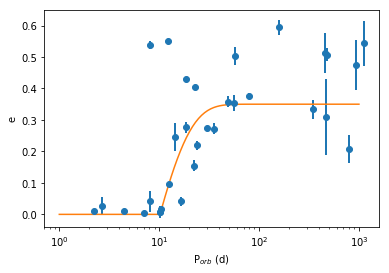

In [21]:
plt.figure()
ax = plt.subplot(111)
plt.errorbar(m35["period"],m35["eccentricity"],m35["ecc_err"],
             linewidth=0,elinewidth=2,capsize=0,marker="o")
plt.plot(ptest,etest)
ax.set_xscale("log")
ax.set_xlabel(r"P$_{orb}$ (d)")
ax.set_ylabel("e")

# Now let's fit it

In [22]:
import emcee
emcee.__version__

u'2.1.0'

In [24]:
def lnlike(Pcirc,Porb,obs_ecc,obs_err):
    mod_ecc = circ_function(Porb,Pcirc)
    
    sigma2 = obs_err**2 + mod_ecc**2
    inv_sigma2 = 1 / sigma2
    return -0.5*np.sum((obs_ecc - mod_ecc)**2 * inv_sigma2
                      - np.log(inv_sigma2))
    

In [25]:
def lnprior(Pcirc):
    if Pcirc>=0.01 and Pcirc<50:
        return 0.0
    else:
        return -np.inf

In [27]:
def lnprob(Pcirc,Porb,obs_ecc,obs_err):
    
    lp = lnprior(Pcirc)
    if not np.isfinite(lp):
        return - np.inf
    else:
        return lp + lnlike(Pcirc,Porb,obs_ecc,obs_err)